# Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, basinhopping #최적화 패키지


# Data collection

In [11]:
price = pd.read_csv('data/adj_close.csv',index_col='Date')
dividend = pd.read_csv('data/dividend_adjusted.csv',index_col='Date')
price = price.set_index(pd.to_datetime(price.index))
dividend = dividend.set_index(pd.to_datetime(dividend.index))
rf = pd.read_csv('data/df_rf.csv',index_col='Date')
rf = rf.set_index(pd.to_datetime(rf.index))
dividend


,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,0.00,0.00,0.24,0.000000,0.185,0.000,0.075,0.000000,0.370,0.000000,...,0.183333,0.58,0.30,0.00,0.00,0.43,0.00,0.00,0.0,0.63
2014-03-01,0.00,0.00,0.00,0.421422,0.000,0.275,0.000,0.712303,0.000,0.531707,...,0.000000,0.00,0.00,0.50,0.00,0.00,0.44,0.16,0.0,0.00
2014-04-01,0.42,0.22,0.00,0.000000,0.000,0.000,0.075,0.000000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.1,0.00
2014-05-01,0.00,0.00,0.24,0.000000,0.185,0.000,0.000,0.000000,0.370,0.000000,...,0.183333,0.58,0.30,0.00,0.00,0.43,0.00,0.16,0.0,0.69
2014-06-01,0.00,0.00,0.00,0.421422,0.000,0.275,0.000,0.712303,0.000,0.531707,...,0.000000,0.00,0.00,0.50,0.00,0.00,0.44,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,1.48,0.51,0.00,0.000000,0.000,0.000,0.320,0.000000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.0,0.00
2023-11-01,0.00,0.00,0.45,0.000000,0.420,0.000,0.000,0.000000,0.805,0.000000,...,0.605000,1.06,0.90,0.81,0.00,1.10,0.00,0.00,0.2,0.95
2023-12-01,0.00,0.00,0.00,1.400000,0.000,0.400,0.000,1.750000,0.000,0.950000,...,0.000000,0.00,0.00,0.00,0.00,0.00,1.22,0.19,0.0,0.00


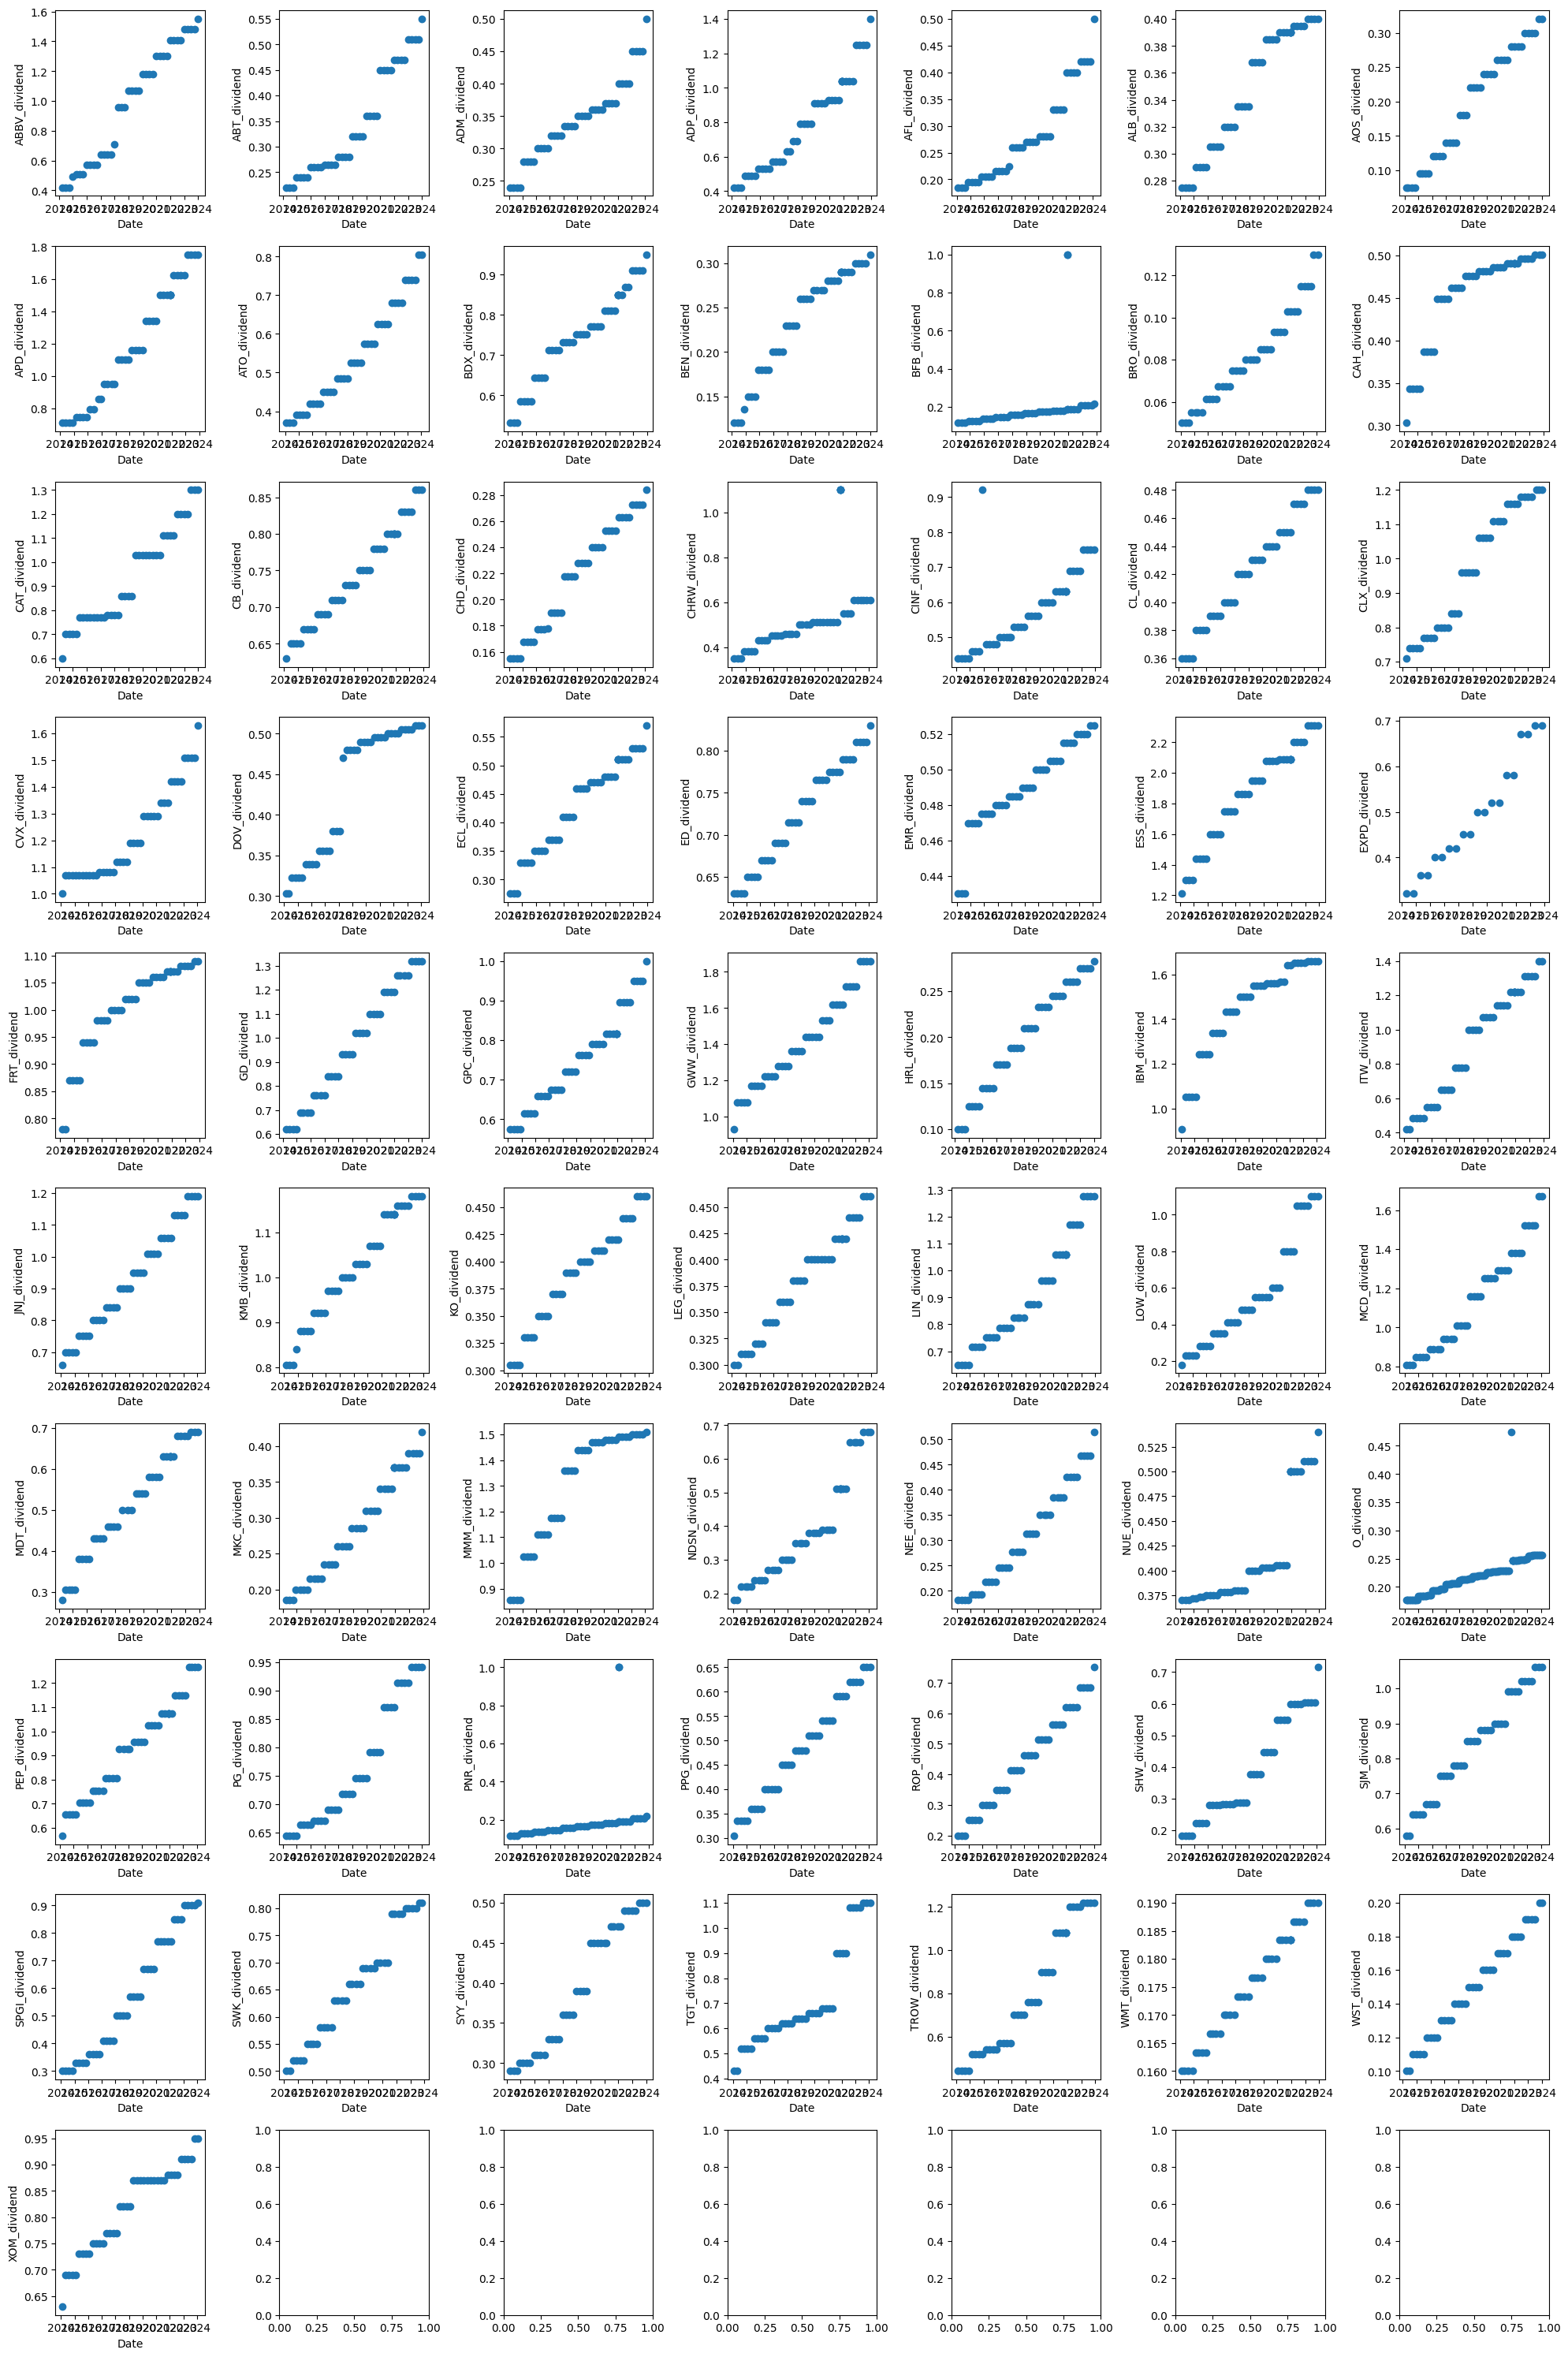

In [6]:
# 10x7 subplot 생성
fig, axs = plt.subplots(10, 7, figsize=(20, 30))

# dividend 데이터의 열 인덱스에 따라 subplot에 그래프 그리기
for i in range(dividend.shape[1]):
    row = i // 7  # 행 인덱스 계산
    col = i % 7   # 열 인덱스 계산
    
    sample = dividend.iloc[:, i]
    #ssample = sample.dropna()
    ssample = sample[sample != 0]
    axs[row, col].scatter(ssample.index, ssample)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel(f'{ssample.name}_dividend')

plt.tight_layout()
plt.show()

In [64]:
start_date = '2014-01-01'
test_div = dividend.loc[start_date:,].fillna(0)
test_div

,ABBV,ABT,ADM,ADP,AFL,ALB,AMCR,AOS,APD,ATO,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-08,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0
2014-01-13,0.4,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0
2014-01-15,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0
2014-01-16,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0
2014-01-17,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-14,0.0,0.00,0.0,0.0,0.0,0.4,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.24,0.208,0.0,0.0
2024-03-18,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0
2024-03-21,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0


In [65]:
month_div = test_div.resample('M').sum()
month_div[month_div!=0]

,ABBV,ABT,ADM,ADP,AFL,ALB,AMCR,AOS,APD,ATO,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-31,0.40,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN
2014-02-28,NaN,NaN,0.24,NaN,0.185,NaN,0.176,0.075,NaN,0.370,...,0.183333,0.58,0.30,NaN,NaN,0.43,NaN,NaN,NaN,0.63
2014-03-31,NaN,NaN,NaN,0.421422,NaN,0.275,NaN,NaN,0.712303,NaN,...,NaN,NaN,NaN,0.50,NaN,NaN,0.44,0.160,NaN,NaN
2014-04-30,0.42,0.22,NaN,NaN,NaN,NaN,NaN,0.075,NaN,NaN,...,NaN,NaN,NaN,NaN,0.29,NaN,NaN,NaN,0.1,NaN
2014-05-31,NaN,NaN,0.24,NaN,0.185,NaN,NaN,NaN,NaN,0.370,...,0.183333,0.58,0.30,NaN,NaN,0.43,NaN,0.160,NaN,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,NaN,NaN,0.45,NaN,0.420,NaN,0.125,NaN,NaN,0.805,...,0.605000,1.06,0.90,0.81,NaN,1.10,NaN,NaN,0.2,0.95
2023-12-31,NaN,NaN,NaN,1.400000,NaN,0.400,NaN,NaN,1.750000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.22,0.190,NaN,NaN
2024-01-31,1.55,0.55,NaN,NaN,NaN,NaN,NaN,0.320,NaN,NaN,...,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,0.2,NaN


# Optimized Weight

In [88]:
class Optimizing(): #(Base_setting)
    """
    Base class for optimizing
    """
    
    def __init__(self,
                price: pd.DataFrame
                ,div: pd.DataFrame
                ,investment_period: list
                ,initial_investment: int
                ):
        
        self.ticker_lst = price.columns.to_list()
        self.price = price
        self.div = div
        self.investment_period = investment_period
        self.start_date = investment_period[0]
        self.end_date = investment_period[1]
        self.initial_investment = initial_investment

        #need to OOP
        self.current_price = (price.loc[self.start_date:]).iloc[0]
        self.period_price = price.loc[:self.start_date]

        self.risk_free = 0.01
        
    
    def obj(self,x): #목적함수 구현
        
        x = np.array(x) 

        seed = np.dot(x, self.current_price) # 전체 투자 금액, 내적 개념, 종목수*종목가격 = 투자금액
        
        weights = (x*self.current_price)/ seed # 투자 비중 / 총투자비용 : [1번종목에 총투자비용대비 얼만큼투자함, ~~~~]
        
        er = self.period_price.iloc[-252:,:].pct_change().dropna().mean()
        
        rf = self.risk_free

        cov = self.period_price.iloc[-252:,:].pct_change().dropna().cov() # 공분산

        variance = np.dot(weights.T, np.dot(cov,weights)) # variance = sigma(wiwjcovij)
        
        std = np.sqrt(variance) #시그마, 표준편차 
        
        standard_ER = np.dot(weights,er)

        # Ep = np.dot(weights,growth_rate) + np.dot(weights,div_rate*(1+growth_rate)) #기대 자본성장률 + 기대배당수익률
        
        standard_sharpe = -(standard_ER-rf)/std
        
        #custom_sharpe = -(Ep-Rf)/std
        
        return standard_sharpe
    
    def optimizing_weight(self):
        """
        Optimize given obj,params,cons to return weight
        """

        #what we need
        # self.ticker_lst
        # self.seed #가용 가능 금액
        # self.period? (투자 기간이 필요할듯) # version 1에서는 과거1년으로 고정
        
        #예상 주당 배당금 ( 추후 Gi 곱을 통해 미래 추정값으로 바꿔야함)
        expect_div = self.div.loc[:str(int(self.start_date[:4])-1)]

        min_month_div = self.initial_investment*(0.01)*(1/12) 

        num_stocks = len(self.ticker_lst)

        #boundary
        bnds = ((0,None), ) * num_stocks # Long only port
        #initial decision variable
        x0 = np.array([100] * num_stocks)
        #setting constraints
        
        #제약식 제약식에 해당하는 등식, 수식을 list 형식으로 모아줌, list 안에는 또 dict 형식으로 넣음)
        #1: 주식분배금액 = 초기 투자금액
        cons = [{'type': 'eq', 'fun': lambda x: np.dot(x,self.current_price)-self.initial_investment}]  # {좌변 - 우변 = 0} 투자할돈 = 들고있는 돈

        #2: 예상 배당금을 매달 300 달러 이상!
        for i in range(0,12):                                  
            cons.append({'type': 'ineq', 'fun': lambda x, i=i: np.dot(x, expect_div.iloc[i,:]) - min_month_div}) 

        #3: 개별 종목 비중이 10% 이상이지 못하게
        for i in range(num_stocks):
            cons.append({'type': 'ineq', 'fun': lambda x: 0.2 - (np.dot(x,self.current_price)/self.initial_investment)}) 


        # collect minimizer_kwargs
        minimizer_kwargs = {"method":"SLSQP", "constraints":cons, "bounds":bnds}
        
        # 전역 최적화를 수행하는 알고리즘으로, 특히 최적화 문제가 복잡하고 지역 최소값(local min)에 갇힐 위험이 있는 경우에 유용합니다.
        # 이 메소드는 여러 시작점에서 로컬 최소화를 시도하여 전역 최소값(global minimum)을 찾는 방식으로 작동합니다.
        res = basinhopping(self.obj, x0, minimizer_kwargs=minimizer_kwargs, niter=10)
        
        weight = (res.x * self.current_price) / np.dot(res.x, self.current_price)  # 최적의 투자 비중
        
        return weight

In [59]:
set(month_div.columns.to_list()) - set(price.columns.to_list())

{'KVUE'}

In [89]:
opt1 = Optimizing(price=price,div=month_div,investment_period=['2015-01-01','2015-12-31'],initial_investment=30000)

weight = opt1.optimizing_weight()

1.0000000000000002

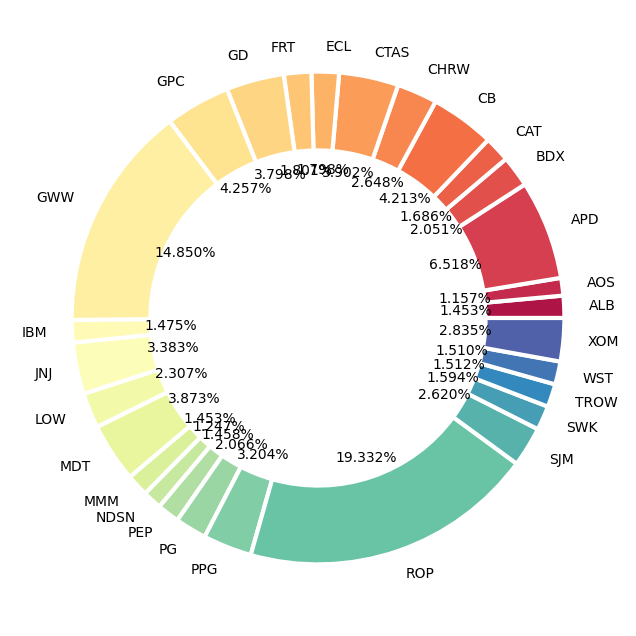

In [93]:
import seaborn as sns

w_lst = []
t_lst = []
for i in range(len(weight)):
    if weight.iloc[i] > (0.01):
        w_lst.append(weight.iloc[i])
        t_lst.append(weight.index[i])
    
pal = sns.color_palette('Spectral', len(w_lst))

plt.figure(figsize=(8, 8))
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
plt.pie(w_lst, labels=t_lst, autopct='%.3f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [96]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Callable, Tuple
from strategies import Strategies
from base_setting import Base_setting
from tool_kits import *
from visualize import visualize
from visualize_v2 import visualize as vs2
from visualize_v3 import visualize as vs3
from performance import *
df_price = pd.read_csv('df_price.csv')
df_spy = pd.read_csv('df_spy.csv')
df_rf = pd.read_csv('df_rf.csv')

def indexing(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(['Date'])
    return df

df_price = indexing(df_price)
df_spy = indexing(df_spy)
df_rf = indexing(df_rf)


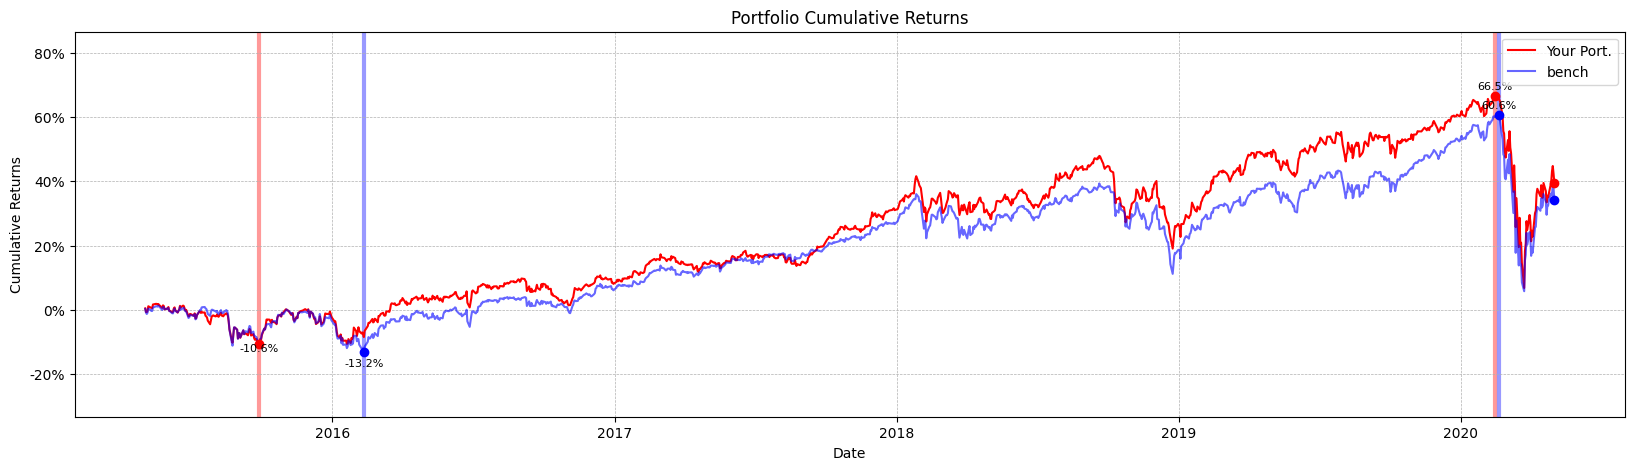

In [100]:
# 투자 유니버스 가격 데이터
data = df_price.copy()

# investment_period = i_p :백테스팅할 투자 기간
i_p = ('2015-05-01','2020-05-01')

# initial_investment = 초기 투자 금액
inv = 10000  # $

# 객체 할당
osj_setting = Base_setting(data=data,investment_period=i_p,initial_investment=inv)
csy_setting = Base_setting(data,i_p,inv)

# 나 이렇게 살거임!
# weight2 =    {'AAPL' : 0.2,
#             # 'GOOG' : 0.2,
#             # 'PEP' : 0.2,
#             # 'KO' : 0.1,
#             # 'MSFT' : 0.1,
#             # 'NVDA' : 0.1,
#             # 'AMZN' : 0.1  
#             # }

weight2 = weight.to_dict()

# # 비중 계산 확인 
# check_weight2_error(weight2)
 
# 투자 기간 동안 buy_and_hold 실시한 결과
buy_and_hold_port_return = csy_setting.run_all(weight2)

#비교할 벤치마크 수익률 계산
bench_return = csy_setting.benchmark_return(df_spy)

# 비교해서 퍼포먼스를 나타내는 시각화 파일
visualize(buy_and_hold_port_return,bench_return)


{'ABBV': 0.004088661443875166,
 'ABT': 0.001986643147253803,
 'ADM': 0.0025086301210158913,
 'ADP': 0.0016361771690169564,
 'AFL': 0.008877245647296916,
 'ALB': 0.012585624475796137,
 'AMCR': 0.0005671375359495648,
 'AOS': 0.010018794323499098,
 'APD': 0.05645646208569154,
 'ATO': 0.0033802220216136705,
 'BDX': 0.017764846589108818,
 'BEN': 0.00649469698700911,
 'BF-B': 0.0023120843912336274,
 'BRO': 0.001111667648539759,
 'CAH': 0.004046445971308811,
 'CAT': 0.014599924902032107,
 'CB': 0.03649143529149538,
 'CHD': 0.005885191398001911,
 'CHRW': 0.022937741070844904,
 'CINF': 5.852708349757033e-17,
 'CL': 0.005516158280144927,
 'CLX': 1.1839933747784359e-05,
 'CTAS': 0.033797552881502484,
 'CVX': 0.005358558033555568,
 'DOV': 0.0021356308847437933,
 'ECL': 0.015577403362942168,
 'ED': 0.004233798408148274,
 'EMR': 0.00961873424058455,
 'ESS': 2.2730678277095477e-16,
 'EXPD': 0.007249600226976009,
 'FRT': 0.015600775048030072,
 'GD': 0.032897999146482025,
 'GPC': 0.03687181037188827,
 

In [268]:
def optimizing_weight(year, investment):
    
    ### 슬라이딩 윈도우 ###
    year1String = str(year-3)
    year2String = str(year-2)
    year3String = str(year-1)
    year_n = str(year)
    
    str1 = year1String + '-01-01'
    str12 = year1String + '-12-31'
    str2 = year2String + '-01-01'
    str22 = year2String + '-12-31'
    str3 = year3String + '-01-01'
    str32 = year3String + '-12-31'
    year_now = year_n + '-01-01'
    year_end = year_n + '-12-31'

    if year == 2023:
      str32 = '2023-11-20' # 2022년은 10-28일까지만 주가 데이터가 있음

    stock_1 = stock.set_index('Date')[str1:str12] # 3년전 1년치
    stock_2 = stock.set_index('Date')[str2:str22] # 2년전 1년치
    stock_3 = stock.set_index('Date')[str3:str32] # 1년전 1년치

    stock_now = stock.set_index('Date')[year_now:year_end] #올해 값

    cov = (0.2 * stock_1.pct_change().fillna(0).cov()) + (0.3 * stock_2.pct_change().fillna(0).cov()) + (0.5 * stock_3.pct_change().fillna(0).cov()) # 공분산
    cov = cov * 252 # 연간 공분산 => 미국 1년 평균 개장일 252일 곱하기

    #목적 함수 제약 함수 활용

    #목적 함수 Parameter 1 : 배당성장률 
    growth_rate = pd.read_excel('data.xlsx', sheet_name='growth_rate', index_col='Unnamed: 0')
    growth_rate = growth_rate.values[3]
    #목적 함수 Parameter 2 : 배당수익률
    div_rate = pd.read_excel('data.xlsx', sheet_name='div_rate',index_col='Unnamed: 0')
    div_rate = div_rate.values[0]
    #목적 함수 Parameter 3 : 무위험수익률 #미국 1년 국채 수익률
    rf = pd.read_excel('data.xlsx', sheet_name='rf')
    Rf = float(rf[rf['date'] == str3]['close'].values)/100
    
    #제약식 Parameter 1 : 내년 예상 배당금 matrix (30*12) (직전 연도 배당 테이블 * 평균배당성장률)
    cons1 = pd.read_excel('data.xlsx', sheet_name='cons1')
    cons1 = cons1[cons1['연도']==year-1].iloc[:,2:] #해당 연도의 배당금 지급
    cons1 = cons1.mul(1+growth_rate)



    if pd.to_datetime(str32) not in np.array(stock['Date']): # 12/31이 영업일이 아닐 때에는 주가 데이터가 없어서 12/30의 데이터를 확인
        str32 = year3String + '-12-30'
    elif pd.to_datetime(str32) not in np.array(stock['Date']):
        str32 = year3String + '-12-29'
    elif pd.to_datetime(str32) not in np.array(stock['Date']):
        str32 = year3String + '-12-28'
    
    price = np.array(stock[stock['Date'] == str32].iloc[0, 1:])

    #제약식 제약식에 해당하는 등식, 수식을 list 형식으로 모아줌, list 안에는 또 dict 형식으로 넣음)
    #1 : 주식분배금액 = 초기 투자금액
    cons = [{'type': 'eq', 'fun': lambda x: np.dot(x,price)-investment}]  # {좌변 - 우변 = 0} 투자할돈 = 들고있는 돈
    #2 : 예상 배당금을 매달 300 달러 이상!
    for i in range(0,12):                                  #1월에 들어올 배당금 >= $300
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: np.dot(x, cons1.iloc[i,:]) - 300})# cons1 =예상 배당금 matrix, cons1.iloc[i,:] --> i 월 행 뽑아내기
        #cons.append({'type': 'ineq', 'fun': lambda x: np.dot(x, cons1.iloc[i,:])-500}) 

    # boundary
    bnds = ((0,None), ) * 30
    # 임의의 초기값 : 전 종목 100개 들고 최적화 시작
    x0 = np.array([100]*30)

    #Global Minimum 찾기 / 최적화 함수에 전달되는 추가 인자들을 설정
    minimizer_kwargs = {"method":"SLSQP", "constraints":cons, "bounds":bnds}
    
    #전역 최적화를 수행하는 알고리즘으로, 특히 최적화 문제가 복잡하고 지역 최소값(local minima)에 갇힐 위험이 있는 경우에 유용합니다.
    # 이 메소드는 여러 시작점에서 로컬 최소화를 시도하여 전역 최소값(global minimum)을 찾는 방식으로 작동합니다.
    res = basinhopping(obj, x0, minimizer_kwargs=minimizer_kwargs, niter=20)
    
    '''
    obj: 최적화할 목적 함수입니다. 이 함수는 최적화 과정에서 최소화되어야 할 값을 반환합니다.
    x0: 최적화를 시작할 때 사용되는 초기 추정값입니다. 이 값은 최적화 과정에서 수정되며 최적의 해를 찾는 데 사용됩니다.
    niter=10: basinhopping 알고리즘의 반복 횟수를 설정합니다. 이 값은 알고리즘이 얼마나 많은 다른 시작점에서 최적화를 시도할지를 결정합니다
    '''
    weight = (res.x * price) / np.dot(res.x, price)  # 최적의 투자 비중
    
    '''
    tickers는 각 주식의 식별자(예: 주식의 이름 또는 코드)를 나타냅니다.
    [format(x, '.2f') for x in res.x]는 각 주식에 투자하는 수량을 소수점 두 자리까지 포맷팅하여 나타냅니다.
    ['{:.2f}%'.format(x * 100) for x in weight]는 각 주식에 대한 투자 비중을 퍼센트(%) 형태로 소수점 두 자리까지 포맷팅하여 나타냅니다.
    zip 함수는 이 세 개의 리스트(tickers, 투자 수량, 투자 비중)를 하나씩 짝지어서 각 주식에 대한 정보를 튜플 형태로 묶어 줍니다.
    ''' 
    pair = [pair for pair in zip(tickers, [format(x, '.2f') for x in res.x],)]
    total =0
    month_expect_div_list = []
    for i in range(0,12):
        i_month_expecting_div = np.dot(res.x,(cons1.iloc[i,:].values))
        month_expect_div_list.append(i_month_expecting_div)

    # 투자 종목 과 비중을 dict 형태로 보여주기
    tickers
    ticker_dictionary = {key : format(weight[i],'.2f') for i,key in enumerate(tickers)} 

    print("최적 투자 비중은 아래와 같습니다.")
    print(ticker_dictionary)

    variance = np.dot(weight.T, np.dot(cov,weight))
    std = np.sqrt(variance)

    df = stock_now * res.x
    df['performance']= df.sum(axis=1)

    return weight, std, month_expect_div_list, df

In [269]:
##### 리밸런싱 함수 #####

def Rebalancing(year, weight, investment):
    price_start = np.array(stock[stock['Date'].apply(lambda x: x.year) == year].iloc[0, 1:]) # 1월 1일 주가
    price_end = np.array(stock[stock['Date'].apply(lambda x: x.year) == year].iloc[-1, 1:]) # 해당 연도 마지막 거래 주가 
    allocation = (weight * investment) / price_start # 종목별 주식 수 list 값으로 저장
    
    div = [] #주식에 1년동안 투자시에 받을 배당금
    for ticker in tickers:
        year_div_data = dividend[dividend['Ex-Dividend Date'].apply(lambda x: x.year) == year]
        div.append(np.sum(year_div_data[year_div_data['Ticker'] == ticker]['Dividend'])) 
    
    monthly_real_div = [] # 월별 실수령 배당금 리스트 -> 생활비로 사용 가정
    for i in range(1, 13):
        #to_frame() : df 형태로 다시 세팅, reset_index() : index 새로 정의 월별 배당금 세팅
        year_div_data = dividend[dividend['Ex-Dividend Date'].apply(lambda x: x.year) == year].groupby(['Month', 'Ticker']).sum()['Dividend'].to_frame().reset_index()
        #해당 연도의 i 월 배당금 지급 금액 행 추출
        year_div_data = year_div_data[year_div_data['Month'] == i].drop('Month', axis=1).set_index('Ticker').T
        # a 리스트에 i 월의 종목별 배당금 지급금액 행을 만듬
        a = []
        for ticker in tickers:
            try: a.append(np.float(year_div_data[ticker]))  # 0에 float 취하면 오류가 생겨서 그런건지 try로 진행해야함
            except: a.append(0)
        monthly = np.dot(allocation, a) # 월별 배당금 내적(i월 배당급 지급급액*투자비중)
        monthly_real_div.append(monthly)

    actual_stock = np.dot(allocation, price_end) # 연말 포트폴리오 가치
    actual_dividend = np.dot(allocation, div) # 배당금 총합
    
    return actual_stock, actual_dividend, monthly_real_div

In [270]:
investment = 300000 # 초기 투자 금액: 30만 달러
tax_cum_d = 0 #세금 누적금액 달러
tax_cum_w = 0 #세금 누적금액 원화
div_cum_d = 0 #배당금 누적금액 달러
div_cum_w = 0 #배당금 누적금액 원화
year_temp = []
weight_temp = []
variance_temp = []
years = [y for y in range(2015, 2023)] # 백테스팅 연도 설정
years = [2021,2022,2023]
performance = pd.DataFrame(columns=tickers)


for year in years:
    weight, variance, month_expect_div_list,df = WeightMeasure(year, investment) # 최적화
    year_temp.append(year)
    weight_temp.append(weight)
    variance_temp.append(variance)
    actual_stock, actual_dividend, monthly_real_div = Rebalancing(year=year, weight=weight, investment=investment) # 1년 주기 리밸런싱
    x0 = investment
    investment = actual_stock
    x1 = actual_stock
    rate = exchange[exchange['Date'].apply(lambda x: x.year) == year]
    profit = x1 - x0 # 수익: 연말 포트폴리오 가치 - 연초 투자 금액
    
    performance = pd.concat([performance,df])

    ### 세금 계산
    if profit * rate.iloc[0, 1] > 2500000:
      tax = ((profit * rate.iloc[0, 1]) - 2500000) * 0.22 # 0.22: 해외주식 수익의 250만원을 제외한 금액에 대해 양도소득세 22% 적용
      x1 = x1 - (tax/rate.iloc[0, 1])
    else:
      tax = 0

    tax_cum_w += tax
    tax_cum_d += tax/rate.iloc[0, 1]

    print('{0}년 세전 포트폴리오 가치: ${1:.2f} / 세금: ${2:.2f} / ￦{4:.0f}\n{0}년 세후 포트폴리오 가치: ${3:.2f}'.format(year, investment, tax/rate.iloc[0, 1], x1, round(tax,-2)))
    print('{}년 세전 배당금: ${:.2f} / 세후 배당금: ${:.2f} / 배당수익률 {:.2f}% '.format(year, actual_dividend, actual_dividend*0.85,actual_dividend/x0*100))
    print('누적 세금 ${:0.2f} / ￦{:.0f}'.format(tax_cum_d,tax_cum_w))
    print('')
    
    investment = x1 # 세후 포트폴리오 가치로 재투자
        
    for i in range(0, 12):
        if year == 2023 and (i == 12 or i ==11): # 데이터 없는 2022년 11월, 12월은 패스
          continue
        else:
          print('{}월 세전 배당금: ${:.2f} / 세후 배당금: ${:.2f} / 원화 배당금 ￦{:.0f}'.format(i+1, month_expect_div_list[i], month_expect_div_list[i]*0.85,round(month_expect_div_list[i]*0.85*rate.iloc[i, 1],-3))) # 0.85: 미국 주식 배당소득세 15% 제외한 후 지급받는 배당금
          div_cum_d += month_expect_div_list[i]*0.85
          div_cum_w += month_expect_div_list[i]*0.85*rate.iloc[i, 1]
    print('누적 실질 수령 배당금 ${:.2f} ￦{:.0f}'.format(div_cum_d,div_cum_w))
    print('\n---------------------------------------------------------')

최적 투자 비중은 아래와 같습니다.
{'WBA': '0.01', 'LEG': '0.01', 'BEN': '0.01', 'SWK': '0.00', 'XOM': '0.01', 'CVX': '0.02', 'BKH': '0.02', 'NFG': '0.01', 'CAT': '0.08', 'TGT': '0.04', 'ITW': '0.07', 'EMR': '0.02', 'APD': '0.10', 'PG': '0.04', 'JNJ': '0.05', 'ATO': '0.03', 'GPC': '0.02', 'GD': '0.04', 'AOS': '0.02', 'HRL': '0.02', 'LOW': '0.05', 'PPG': '0.03', 'PH': '0.09', 'ABM': '0.01', 'ADM': '0.01', 'ABT': '0.04', 'CWT': '0.02', 'ADP': '0.07', 'TNC': '0.02', 'DOV': '0.01'}
2021년 세전 포트폴리오 가치: $380753.18 / 세금: $17302.72 / ￦20554900
2021년 세후 포트폴리오 가치: $363450.46
2021년 세전 배당금: $7453.22 / 세후 배당금: $6335.24 / 배당수익률 2.48% 
누적 세금 $17302.72 / ￦20554942

1월 세전 배당금: $497.46 / 세후 배당금: $422.84 / 원화 배당금 ￦502000
2월 세전 배당금: $757.10 / 세후 배당금: $643.53 / 원화 배당금 ￦761000
3월 세전 배당금: $573.00 / 세후 배당금: $487.05 / 원화 배당금 ￦572000
4월 세전 배당금: $525.93 / 세후 배당금: $447.04 / 원화 배당금 ￦529000
5월 세전 배당금: $763.38 / 세후 배당금: $648.87 / 원화 배당금 ￦752000
6월 세전 배당금: $546.56 / 세후 배당금: $464.58 / 원화 배당금 ￦535000
7월 세전 배당금: $553.29 / 세후 배당금: $470.

In [271]:
weight, std, month_expect_div_list, df =WeightMeasure(2021,300000)

최적 투자 비중은 아래와 같습니다.
{'WBA': '0.01', 'LEG': '0.01', 'BEN': '0.01', 'SWK': '0.00', 'XOM': '0.01', 'CVX': '0.02', 'BKH': '0.02', 'NFG': '0.01', 'CAT': '0.10', 'TGT': '0.03', 'ITW': '0.08', 'EMR': '0.01', 'APD': '0.11', 'PG': '0.04', 'JNJ': '0.05', 'ATO': '0.03', 'GPC': '0.02', 'GD': '0.04', 'AOS': '0.03', 'HRL': '0.02', 'LOW': '0.06', 'PPG': '0.02', 'PH': '0.09', 'ABM': '0.01', 'ADM': '0.01', 'ABT': '0.04', 'CWT': '0.02', 'ADP': '0.08', 'TNC': '0.01', 'DOV': '0.00'}


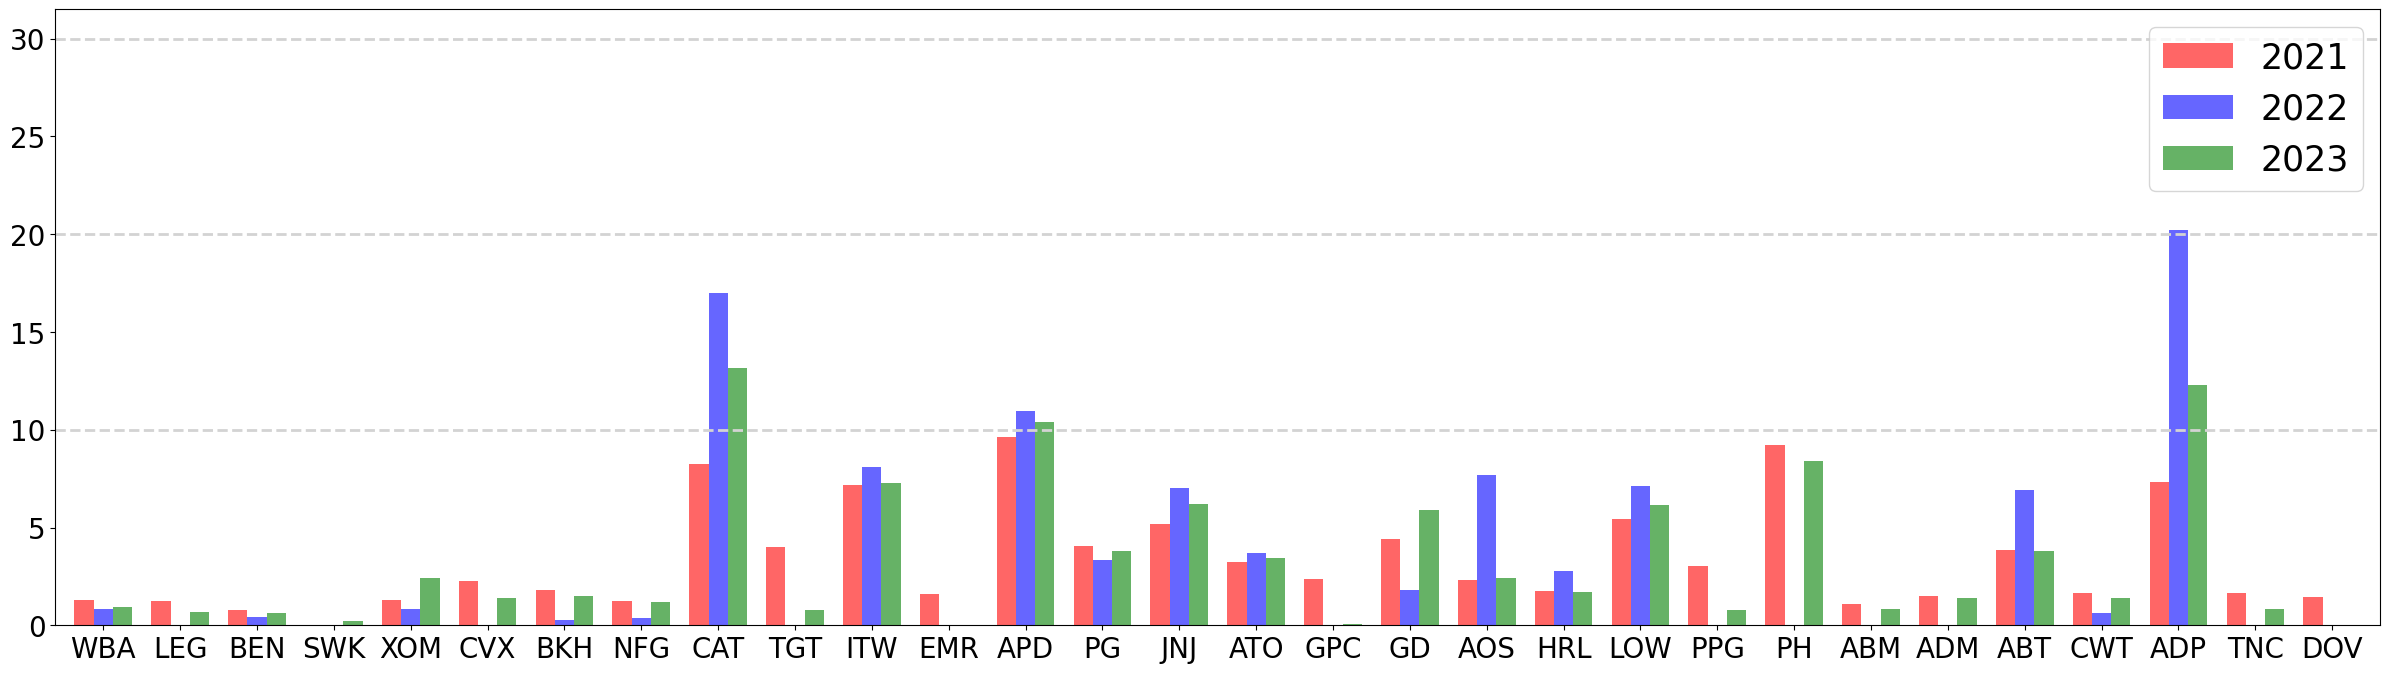

In [272]:
### 연도별 최적 투자 비중 그래프 ###
import matplotlib.pyplot as plt

weight_temp_ = []
for i in range(len(weight_temp)):
    weight_temp_.append(weight_temp[i] * 100)
    
graph = pd.DataFrame(weight_temp_, columns=tickers, index=years).T.reset_index()

graph.plot(x="index", y=years, kind="bar",color=['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'cyan'], alpha = 0.6, width = 0.75, figsize=(30,8))
plt.axhline(10, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.axhline(20, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.axhline(30, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.xticks(np.arange(len(tickers)), tickers, rotation=0, fontsize=20)
plt.yticks(np.arange(0, 35, 5), fontsize=20)
plt.legend(fontsize=25, loc='upper right')
plt.xlabel(None)
plt.show()

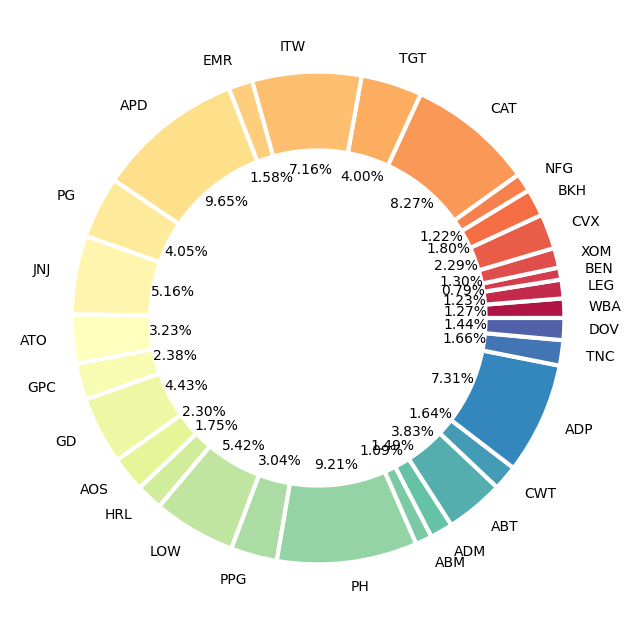

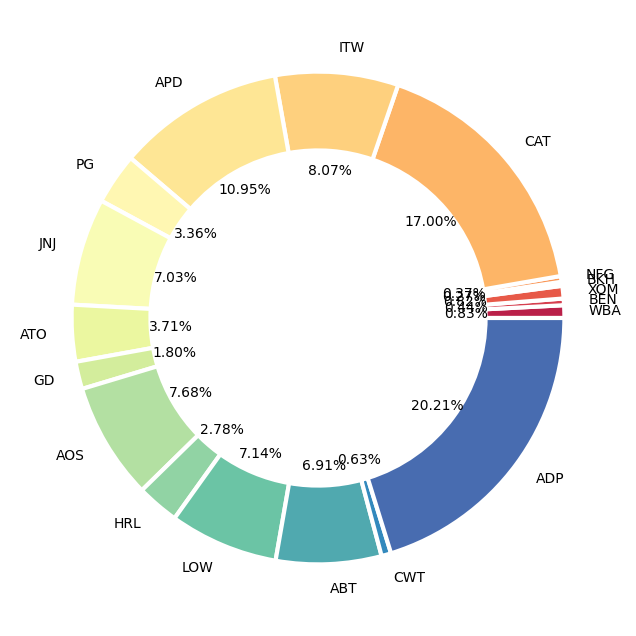

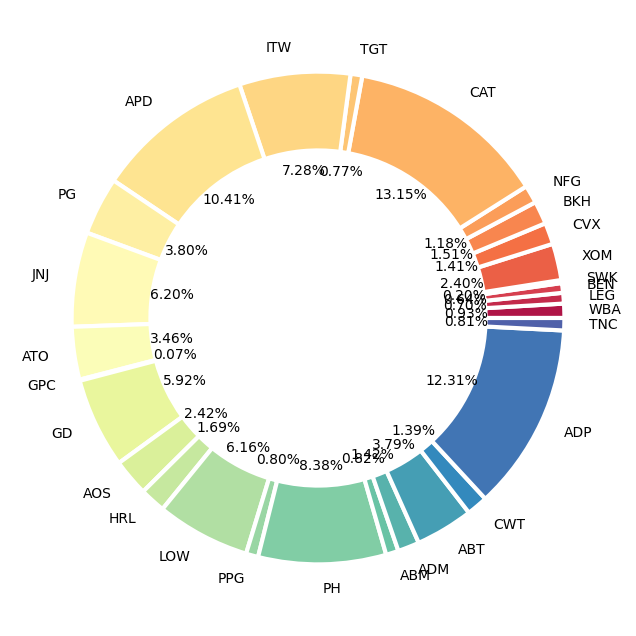

In [273]:
import seaborn as sns

for j in range(3):       
    list = []
    for i in range(30):
        if weight_temp[j][i]>0.0005:
            list.append([i,weight_temp[j][i]])
    t_list = []
    w_list = []
    for i in list:
        tic,wet = tickers[i[0]], i[1]
        t_list.append(tic)
        w_list.append(wet)

    pal = sns.color_palette('Spectral', len(t_list))

    plt.figure(figsize=(8, 8))
    wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
    plt.pie(w_list, labels=t_list, autopct='%.2f%%', wedgeprops=wedgeprops, colors=pal)
    plt.show()

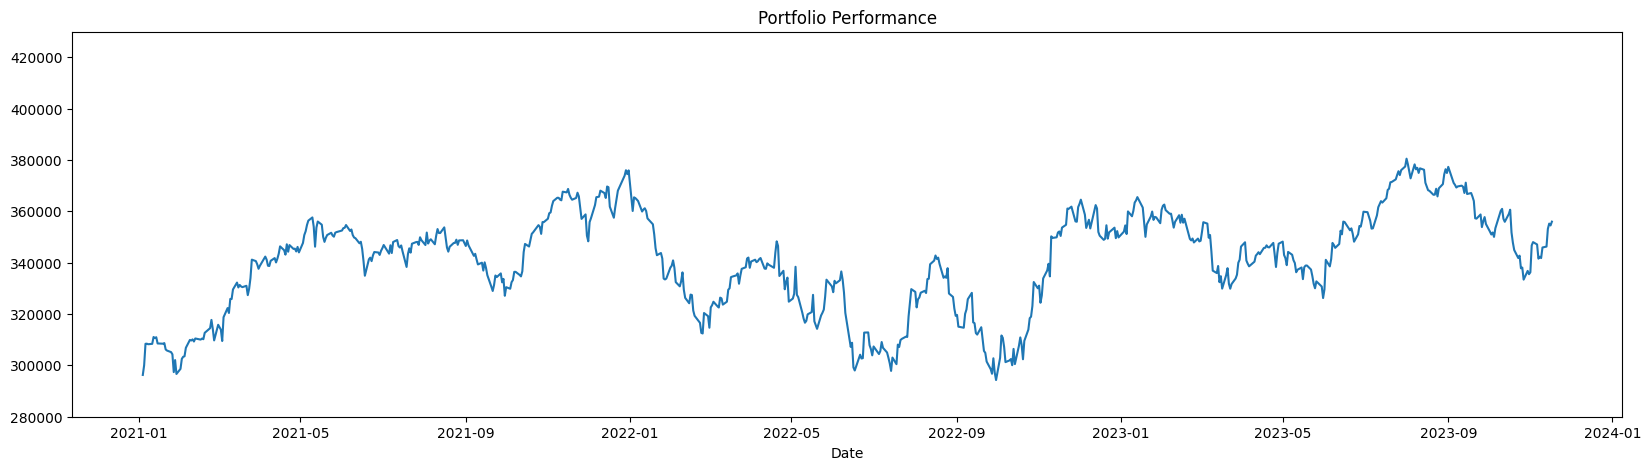

In [274]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(performance['performance'])  # 막대 그래프로 표현
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylim(280000, 430000)
plt.show()


In [275]:
sharpe_res = pd.read_excel('data.xlsx', sheet_name='sharpe_res',index_col='Date')
sharpe_res

,1,2,3,4,5,6,7,8,9,10,11,12,sum
Date,,,,,,,,,,,,,
2021,415.40,827.25,563.48,446.00,832.95,536.14,474.34,901.95,527.79,434.58,911.50,512.14,7383.52
2022,700.94,443.96,696.48,706.20,459.72,697.95,752.94,460.53,700.11,767.19,470.22,729.48,7585.72
2023,709.44,614.64,702.84,720.37,668.85,815.57,650.69,673.19,706.65,775.31,505.17,NaN,7542.72


In [288]:
print(sharpe_res['sum'].sum()/300000,performance['performance'].tail(1).values[0]/300000)
print(sharpe_res['sum'].sum()/300000+performance['performance'].tail(1).values[0]/300000)

0.07503986666666666 1.1866703919544734
1.2617102586211402


In [276]:
sharpe_res*0.85

,1,2,3,4,5,6,7,8,9,10,11,12,sum
Date,,,,,,,,,,,,,
2021,353.090,703.1625,478.958,379.1000,708.0075,455.7190,403.1890,766.6575,448.6215,369.3930,774.7750,435.319,6275.992
2022,595.799,377.3660,592.008,600.2700,390.7620,593.2575,639.9990,391.4505,595.0935,652.1115,399.6870,620.058,6447.862
2023,603.024,522.4440,597.414,612.3145,568.5225,693.2345,553.0865,572.2115,600.6525,659.0135,429.3945,NaN,6411.312


In [277]:
soren_res = pd.read_excel('data.xlsx', sheet_name='soren_res',index_col='Date')
soren_res

,1,2,3,4,5,6,7,8,9,10,11,12,sum
Date,,,,,,,,,,,,,
2021,1233.48,500.00,500,1233.48,500.00,511.38,1233.59,500.00,511.49,1295.55,500.00,511.5,9030.47
2022,1268.23,500.00,500,1268.23,500.00,503.84,1275.03,500.00,517.07,1313.81,505.75,522.0,9173.96
2023,1187.63,517.76,500,1187.63,547.87,503.28,1203.68,547.87,515.25,1250.28,500.00,NaN,8461.25


In [280]:
soren_res['sum'].sum()

26665.68

In [278]:
dividend = pd.read_excel('data.xlsx', sheet_name='dividend') # 2000년 ~ 2023년, 30개 종목의 배당금 데이터
cons12 = pd.read_excel('data.xlsx', sheet_name='cons1') #월별 배당금 제약조건 1
tickers = cons12.T.index[2:].to_list() #tickers list
stock = pd.read_excel('data.xlsx', sheet_name='stock_price') # 2000-01-03 ~ 2023-11-28, 30개 종목의 주가 데이터
exchange = pd.read_excel('data.xlsx', sheet_name='exchange_rate') # 2000-01 ~ 2023-11, 한 달 평균 환율 데이터
# 데이터 전처리: 날짜 데이터 타입으로 변환
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

dividend['Ex-Dividend Date'] = pd.to_datetime(dividend['Ex-Dividend Date'])
dividend = dividend.sort_values('Ex-Dividend Date')
dividend['Month'] = dividend['Ex-Dividend Date'].apply(lambda x: x.month)  # 월 feature 추가

exchange['Date'] = pd.to_datetime(exchange['Date'])
growth_rate = pd.read_excel('data.xlsx', sheet_name='growth_rate', index_col='Unnamed: 0')
growth_rate.tail(1)


,1,2,3,4,5,6,7,8,9,10,11,12,sum
Date,,,,,,,,,,,,,
2021,1048.4580,425.000,425.0,1048.4580,425.0000,434.673,1048.5515,425.0000,434.7665,1101.2175,425.0000,434.775,7675.8995
2022,1077.9955,425.000,425.0,1077.9955,425.0000,428.264,1083.7755,425.0000,439.5095,1116.7385,429.8875,443.700,7797.8660
2023,1009.4855,440.096,425.0,1009.4855,465.6895,427.788,1023.1280,465.6895,437.9625,1062.7380,425.0000,NaN,7192.0625
